# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### Open Street Map

In [1]:
from straeto.data import get_osm_data

#get_osm_data(verbose=True)

In [2]:
!printf 'osm-data:\n' && ls osm-data/ && printf '\nosm-data/output:\n' && ls osm-data/output

osm-data:
gis_osm_roads_free_1.cpg  gis_osm_roads_free_1.prj  gis_osm_roads_free_1.shx
gis_osm_roads_free_1.dbf  gis_osm_roads_free_1.shp  output

osm-data/output:
extracted_roads.cpg  extracted_roads.shx     no_extracted_roads.shp
extracted_roads.dbf  no_extracted_roads.cpg  no_extracted_roads.shx
extracted_roads.prj  no_extracted_roads.dbf
extracted_roads.shp  no_extracted_roads.prj


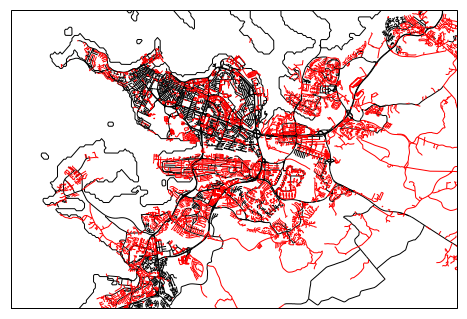

In [3]:
from straeto import straeto
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig, ax = straeto.get_map(region='reykjavik', res='f')

ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp', edgecolor='red')

plt.show()

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [4]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 34,
 'route': '1-A',
 'gpsTime': '180531173654',
 'lat': 64.1474416666667,
 'lon': -21.9362666666667,
 'speed': 0.02,
 'heading': 217.58,
 'gpsFix': 2,
 'routeNumber': '1',
 'lastStop': 90000055,
 'nextStop': 90000056,
 'pingCode': 6}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

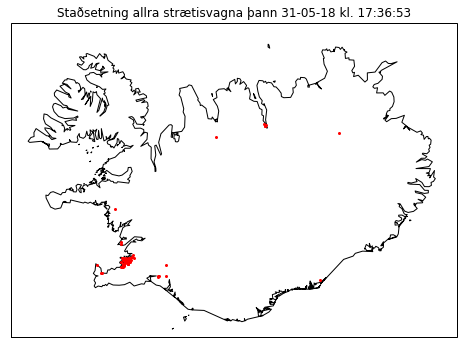

In [5]:
from datetime import datetime

fig, ax = straeto.get_map(region='iceland')

for bus in api.getAllBusPositions():
    plt.plot(bus['lon'], bus['lat'], marker='o', color='red', markersize=2,
             transform=ccrs.Geodetic())

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [6]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

73 73


In [7]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
43-C | k = 49.63 / 26.2 = 1.89 | 23.67 --> 28.74
51-B | k = 87.92 / 47.58 = 1.85 | 47.57 --> 47.58
11-D | k = 17.96 / 10.46 = 1.72 | 6.17 --> 14.76
18-E | k = 49.35 / 26.9 = 1.83 | 25.49 --> 28.31
2-R | k = 45.55 / 24.92 = 1.83 | 25.74 --> 24.11
1-I | k = 6.18 / 3.43 = 1.8 | 3.95 --> 2.91
3-D | k = 29.6 / 15.9 = 1.86 | 15.07 --> 16.74
12-E | k = 44.07 / 23.45 = 1.88 | 22.28 --> 24.62
2-E | k = 27.42 / 15.07 = 1.82 | 13.16 --> 16.99
1-L | k = 49.69 / 26.46 = 1.88 | 29.34 --> 23.59
12-B | k = 30.27 / 16.95 = 1.79 | 16.08 --> 17.82
73-A | k = 98.31 / 53.0 = 1.85 | 53.01 --> 52.99
4-F | k = 26.69 / 14.11 = 1.89 | 13.67 --> 14.55
15-C | k = 77.34 / 41.95 = 1.84 | 40.6 --> 43.29
1-C | k = 6.7 / 3.79 = 1.77 | 5.1 --> 2.49
18-A | k = 80.04 / 43.09 = 1.86 | 42.49 --> 43.69
43-A | k = 31.33 / 17.09 = 1.83 | 15.98 --> 18.19
2-C | k = 49.24 / 26.25 = 1.88 | 26.4 --> 26.1
72-A | k = 37.52 / 20.77 = 1.81 | 22.02 --> 19.52
55-A | k = 78.59 / 42.84 = 1.83 | 44.83 --> 40.84
5-A | k = 35.17 / 20.1

## Undirbúningur gagna:
Load sqlite files:
```
pgloader 25-03-2018.db postgresql:///straeto
```
Started 22:37
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r ORDER BY b.geom <-> r.geom LIMIT 1);
```
Aðeins hraðara: (37-39 sec með index)
```
UPDATE buses b SET maxspeed = (SELECT r.maxspeed FROM roads r WHERE ST_Expand(b.geom, 0.012) && r.geom ORDER BY b.geom <-> r.geom LIMIT 1);
```

In [8]:
%alias sql psql straeto -c

In [9]:
sql "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | buses           | table | arni
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(3 rows)



In [10]:
#sql "ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);"

In [11]:
#sql "UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);"

In [12]:
#sql "CREATE INDEX buses_gix ON buses USING gist(geom);"

In [13]:
#sql "VACUUM ANALYZE;"

In [14]:
#sql "ALTER TABLE buses ADD maxspeed integer;"

## Úrvinnsla gagna:

In [15]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

connection = pg.connect(database='straeto',
                        # Location of .s.PGSQL.5432 file;
                        # try host='/tmp' if you get an error.
                        host='/var/run/postgresql')
df = pd_sql.read_sql("SELECT gps_time, route_number, lat, lon, speed, maxspeed FROM buses;", connection)

In [16]:
df['gps_time'] = pd.to_datetime(df['gps_time'], format='%y%m%d%H%M%S')
df['speed'] = df['speed']*1.85

In [17]:
df = df.set_index('gps_time')

In [18]:
df.head(3)

,route_number,lat,lon,speed,maxspeed
gps_time,,,,,
2018-03-24 23:58:05,12,64.1280,-21.9471,0.0000,0
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30


In [19]:
df = df.query('maxspeed > 0')
df['ratio'] = df['speed']/df['maxspeed']

In [20]:
over = df.query('maxspeed < speed')
under = df.query('maxspeed >= speed')

In [21]:
df.head(8)

,route_number,lat,lon,speed,maxspeed,ratio
gps_time,,,,,,
2018-03-24 23:58:07,3,64.1330,-21.8965,50.9675,60,0.849458
2018-03-24 23:58:06,7,64.1689,-21.6923,19.9615,30,0.665383
2018-03-24 23:58:05,15,64.1455,-21.9677,28.3235,30,0.944117
2018-03-24 23:58:05,12,64.1243,-21.8482,61.3645,60,1.022742
2018-03-24 23:58:05,15,64.1628,-21.7282,27.5465,50,0.550930
2018-03-24 23:58:05,3,64.1455,-21.9245,22.2555,30,0.741850
2018-03-24 23:58:08,18,64.1287,-21.7731,68.9495,80,0.861869
2018-03-24 23:58:07,28,64.1101,-21.8880,24.6790,50,0.493580


In [22]:
print(len(over), len(under), round(len(over)*100/len(under), 1))

64434 331371 19.4


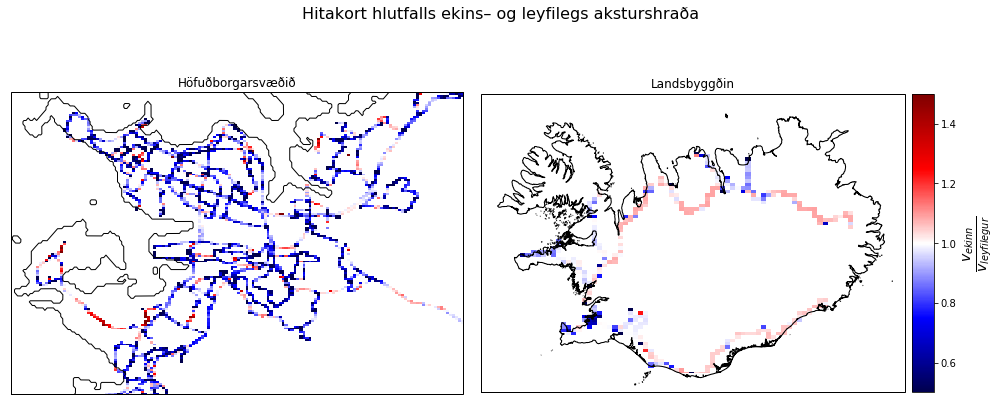

In [23]:
%matplotlib inline
import numpy as np

x = df['lon']
y = df['lat']
ratios = df['ratio']

fig, (ax, ax2) = straeto.get_map(region=[['reykjavik', 1.15], 'iceland'], res='f',
                                 figsize=(14, 7), shape=(1, 2))
# The heatmap itself
im = straeto.add_heatmap(ax, x, y, ratios, bins=4000, statistic='median')
im = straeto.add_heatmap(ax2, x, y, ratios, bins=65, statistic='median')
# The colourbar
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

fig.suptitle('Hitakort hlutfalls ekins– og leyfilegs aksturshraða', size=16)
ax.set_title('Höfuðborgarsvæðið')
ax2.set_title('Landsbyggðin')

fig.tight_layout()
plt.subplots_adjust(top=1)
plt.show()

In [24]:
df_23 = df.query('route_number == "23"')
df_23.head(3)

,route_number,lat,lon,speed,maxspeed,ratio
gps_time,,,,,,
2018-03-25 09:21:39,23,64.0897,-21.9299,0.0000,30,0.000000
2018-03-25 09:21:49,23,64.0897,-21.9299,0.0185,30,0.000617
2018-03-25 09:21:59,23,64.0897,-21.9298,0.0925,30,0.003083


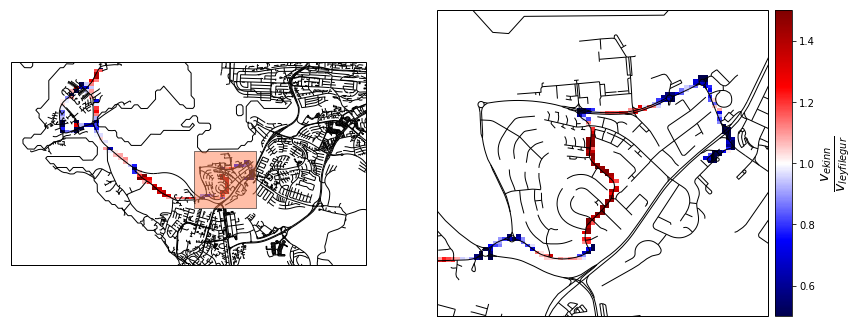

In [32]:
import shapely.geometry as sgeom

box = sgeom.box(minx=-21.957609, maxx=-21.925687, miny=64.082863, maxy=64.095775)
x0, y0, x1, y1 = box.bounds

x = df_23['lon']
y = df_23['lat']
ratios = df_23['ratio']

fig, (ax, ax2) = straeto.get_map(region=[[[-22.043032, -21.878363, 64.072429, 64.113672], 0.9],
                                 [[x0, x1, y0, y1], 0.9]],
                          res='f', figsize=(14, 7), shape=(1, 2))

ax2 = straeto.add_shapefile(ax2, 'osm-data/output/extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/extracted_roads.shp')
ax2 = straeto.add_shapefile(ax2, 'osm-data/output/no_extracted_roads.shp')
ax = straeto.add_shapefile(ax, 'osm-data/output/no_extracted_roads.shp')

im = straeto.add_heatmap(ax, x, y, ratios, bins=40, statistic='median')
ax.add_geometries([box], ccrs.PlateCarree(), facecolor='coral', edgecolor='black', alpha=0.5)

im = straeto.add_heatmap(ax2, x, y, ratios, bins=200, statistic='median')
straeto.add_colorbar(fig, ax2, im, label='$\\frac{v_{ekinn}}{v_{leyfilegur}}$')

plt.show()

In [26]:
df.groupby(['route_number']).median().sort_values(by=['ratio'], ascending=False)

,lat,lon,speed,maxspeed,ratio
route_number,,,,,
56,65.59370,-16.49590,94.68300,90,1.060564
51,63.95780,-20.98780,85.57175,90,0.979328
73,64.01220,-20.74350,86.42275,90,0.977006
57,64.54120,-21.73400,84.69300,90,0.976800
72,64.02790,-20.73090,86.32100,90,0.976594
52,63.94420,-20.99930,82.84300,90,0.972175
59,65.06510,-21.74570,86.52450,90,0.965330
78,65.93835,-18.40560,79.35575,90,0.950694
58,64.75520,-22.24960,84.85950,90,0.948228
